In [1]:
#importing Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10


from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

import yfinance as yf

In [2]:
# reading csv file 
stock_symbol = 'TATAMOTORS.NS'
df=yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
#checking the dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1236 entries, 2017-04-03 to 2022-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1236 non-null   float64
 1   High       1236 non-null   float64
 2   Low        1236 non-null   float64
 3   Close      1236 non-null   float64
 4   Adj Close  1236 non-null   float64
 5   Volume     1236 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 67.6 KB


In [4]:
#checking the dataset for null values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

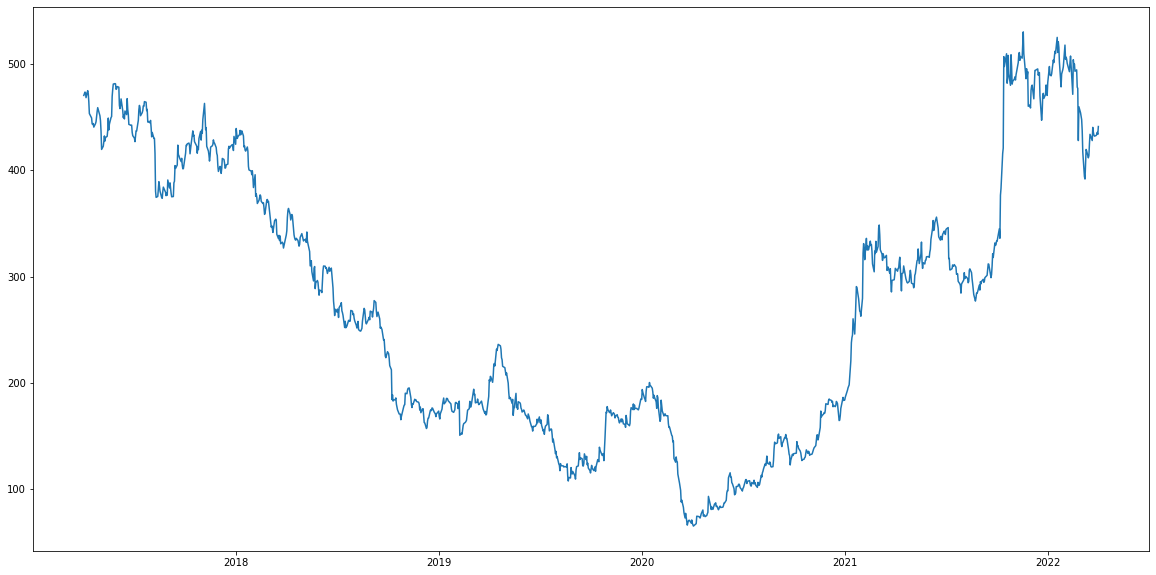

In [5]:
#Analyze the closing prices from dataframe
plt.plot(df["Close"],label='Close Price history')

In [6]:
close = df['Close']
ds = close.values
ds_scaled = scaler.fit_transform(np.array(ds).reshape(-1,1))

In [7]:
#Defining test and train data sizes
train_size=int(len(ds_scaled)*0.80)
test_size=len(ds_scaled)-train_size

In [8]:
train_size,test_size

(988, 248)

In [9]:
#splitting data between train and test
ds_train =ds_scaled[0:train_size,:]
ds_test = ds_scaled[train_size:len(ds_scaled),:1]

In [10]:
#creating dataset in time series for LSTM model
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a=dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain) 

In [11]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, Y_train = create_ds(ds_train,time_stamp)
X_test, Y_test = create_ds(ds_test,time_stamp)

In [12]:
#Reshaping data to fit into LSTM model
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [13]:
#Build and train the LSTM model
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(X_train,Y_train,epochs=1,batch_size=1,verbose=2)

887/887 - 58s - loss: 0.0028 - 58s/epoch - 65ms/step


In [14]:
lstm_model.save("saved_lstm_model.h5")

In [13]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [15]:
#model evaluation
score = lstm_model.evaluate(X_train,Y_train,verbose=0)
print(' Train accuracy:', score)

 Train accuracy: 0.0007405760115943849


In [14]:
#predicting on train and test data
train_predict = lstm_model.predict(X_train)
test_predict = lstm_model.predict(X_test)

In [17]:
#Inverse transform to get actual data
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

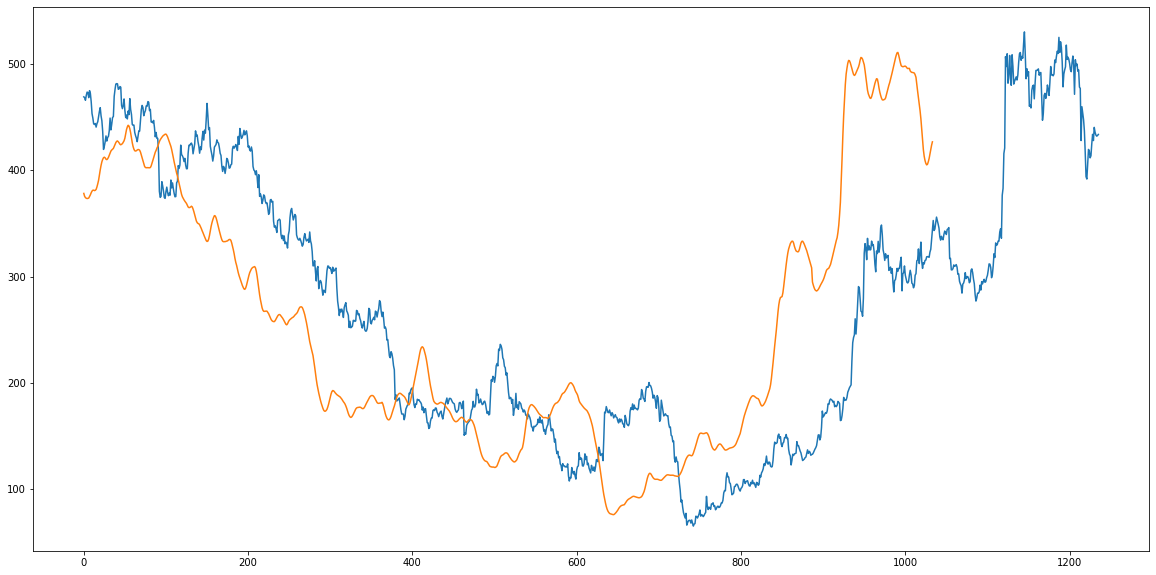

In [18]:
#comparing using visuals
#comparing using visuals
test = np.vstack((train_predict,test_predict))
plt.plot(scaler.inverse_transform(ds_scaled))
plt.plot(test)

In [19]:
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Close'])

data=df.sort_index(ascending=True,axis=0)
new_dataset.index=df.index

for i in range(0,len(data)):
    new_dataset["Close"][i]=data["Close"][i]

train_size=int(len(new_dataset)*0.80)
valid_size=len(new_dataset)-train_size

In [20]:
train_size,valid_size

(988, 248)

In [21]:
#splitting data between train and test
train_data=new_dataset[:train_size+101]
valid_data=new_dataset[train_size+101:]

C:\Users\hp\AppData\Local\Temp/ipykernel_15628/3271566683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=test_predict


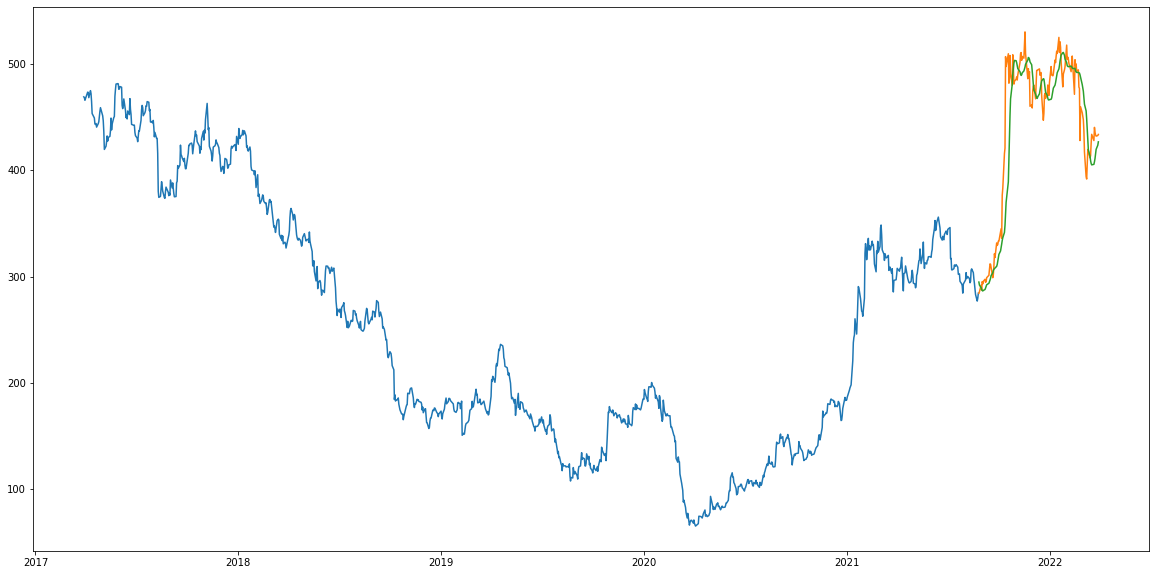

In [23]:
valid_data['Predictions']=test_predict
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

In [24]:
#comparing the actual and predicted closing price
valid_data[['Close',"Predictions"]]

,Close,Predictions
Date,,
2021-08-26,284.299988,294.830902
2021-08-27,285.75,291.999878
2021-08-30,291.950012,289.571075
2021-08-31,287.299988,287.724060
2021-09-01,295.25,286.896576
...,...,...
2022-03-23,435.799988,411.049408
2022-03-24,433.200012,415.335052
2022-03-25,432.100006,419.685852


In [25]:
len(ds_test)

248

In [26]:
#getting the last 100 days records
fut_inp=ds_test[148:]
fut_inp=fut_inp.reshape(1,-1)
tmp_inp=list(fut_inp)
fut_inp.shape

(1, 100)

In [27]:
#creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [28]:
#Predicting next 30 days price using the current data
#it will predict in sliding window manner (algoriths) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp= fut_inp.reshape((1, n_steps,1))
        yhat = lstm_model.predict(fut_inp,verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1,n_steps,1))
        yhat = lstm_model.predict(fut_inp,verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

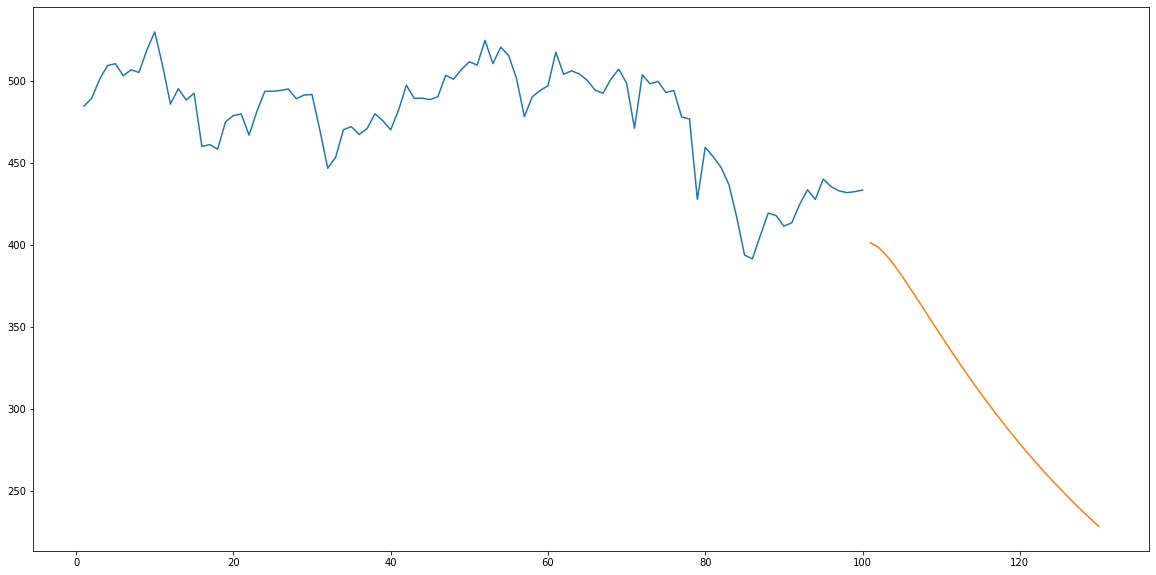

In [28]:
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)
plt.plot(plot_new, scaler.inverse_transform(ds_scaled[1136:]))
plt.plot(plot_pred, scaler.inverse_transform(lst_output))

In [29]:
ds_new = ds_scaled.tolist()
len(ds_new)

1236

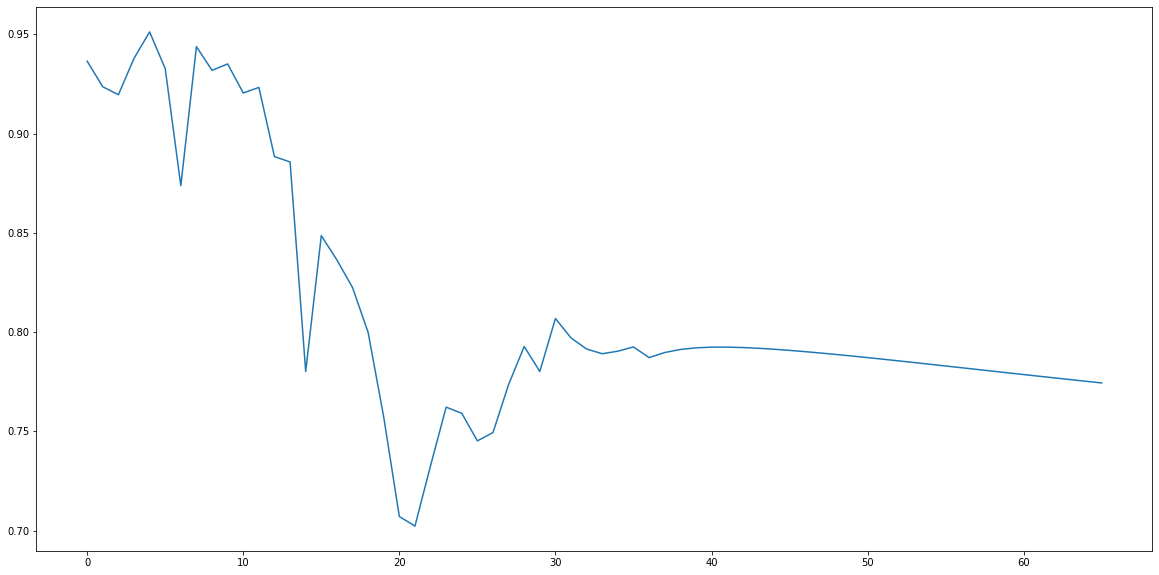

In [30]:
#Extends helps us to fill the missing value approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [31]:
#creating the final data for plotting
final_graph = scaler.inverse_transform(ds_new).tolist()

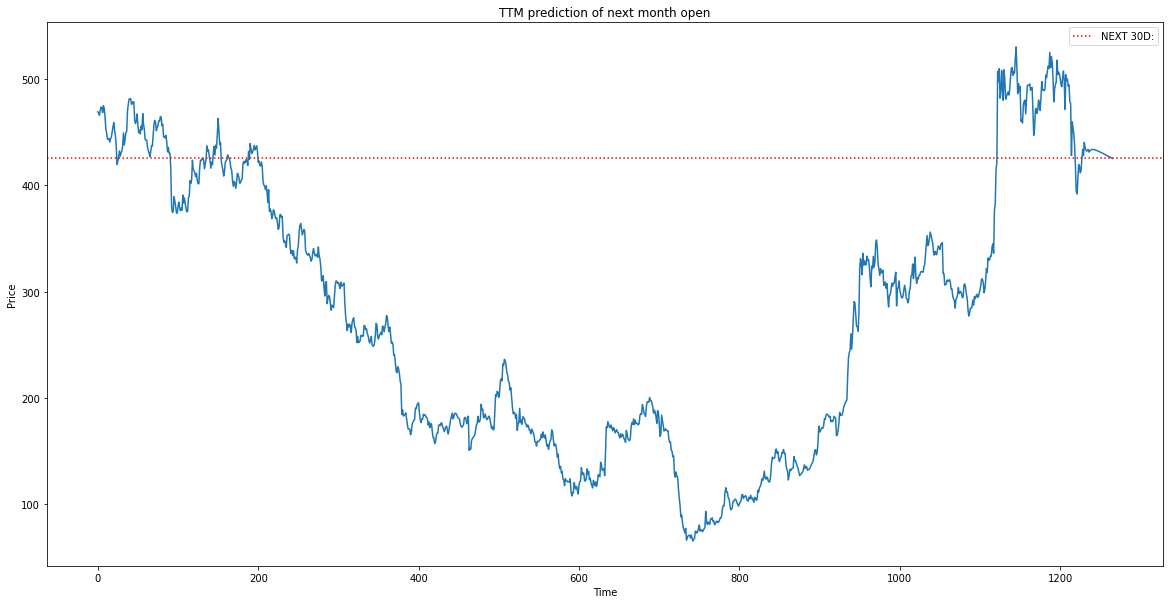

In [32]:
#plotting final results with predicted value after 30 days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("TTM prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1],color='red',linestyle=':',label='NEXT 30D:')
plt.legend()